In [ ]:
# Install required libraries
!pip install torch torchvision opencv-python pillow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.1 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [1]:
# Import libraries
import os
import random
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import cv2

In [ ]:
import gdown
import os

def download_if_needed(file_id, output_name):
    if not os.path.exists(output_name):
        print(f"Downloading {output_name}...")
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, output_name, quiet=False)
    else:
        print(f"{output_name} already exists, skipping download")

file_id_1 = "1MmGgHCO2gREQ7NXUozXqYZAnQQCr02Qs"
output_1 = "fake_000000.zip"
download_if_needed(file_id_1, output_1)

file_id_2 = "1Mnp2JCnRx1jjorvhEDiLY5Wli1ZV-oMT"
output_2 = "fake_010000.zip"
download_if_needed(file_id_2, output_2)

os.makedirs("/kaggle/working/fake_000000", exist_ok=True)
os.makedirs("/kaggle/working/fake_010000", exist_ok=True)

if os.path.exists(output_1) and not os.listdir("/kaggle/working/fake_000000"):
    !unzip -q fake_000000.zip -d /kaggle/working/fake_000000

if os.path.exists(output_2) and not os.listdir("/kaggle/working/fake_010000"):
    !unzip -q fake_010000.zip -d /kaggle/working/fake_010000

fake_000000.zip already exists, skipping download
fake_010000.zip already exists, skipping download


Number of real images: 52001
Number of fake images (000): 1000
Number of fake images (010): 1000
Total fake images: 2000


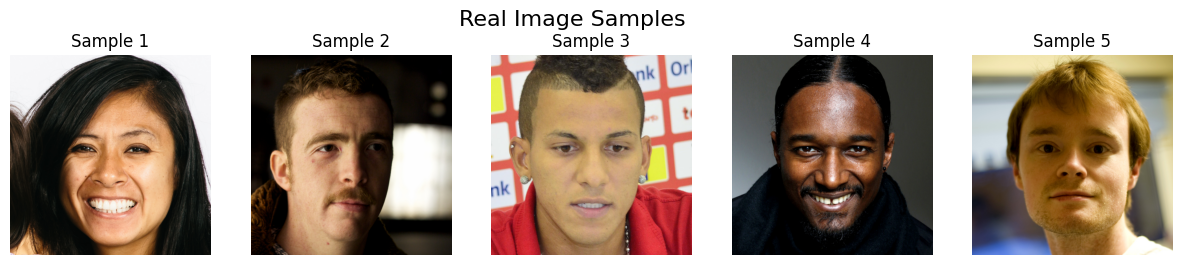

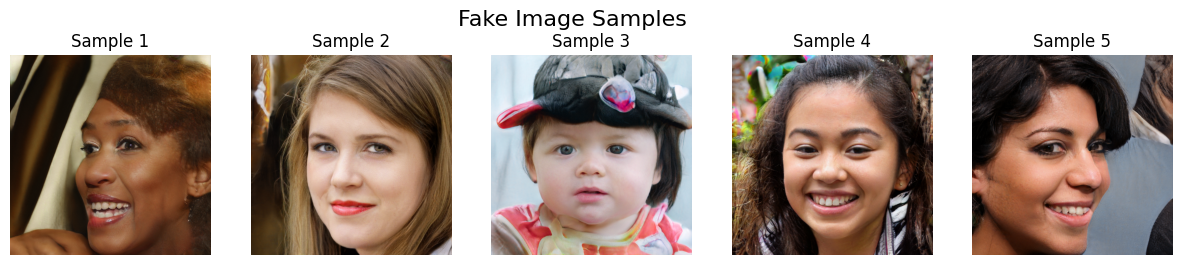

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

real_images_path = "/kaggle/input/flickrfaceshq-dataset-ffhq"
real_images = [f for f in os.listdir(real_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Number of real images: {len(real_images)}")

fake_images_000 = [f for f in os.listdir("/kaggle/working/fake_000000") if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
fake_images_010 = [f for f in os.listdir("/kaggle/working/fake_010000") if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Number of fake images (000): {len(fake_images_000)}")
print(f"Number of fake images (010): {len(fake_images_010)}")
print(f"Total fake images: {len(fake_images_000) + len(fake_images_010)}")

def display_samples(image_paths, title, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)

    sampled_paths = random.sample(image_paths, min(num_samples, len(image_paths)))

    for i, img_path in enumerate(sampled_paths):
        plt.subplot(1, num_samples, i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    plt.show()

# Display real samples
real_image_paths = [os.path.join(real_images_path, img) for img in real_images]
display_samples(real_image_paths, "Real Image Samples")

fake_image_paths = ([os.path.join("/kaggle/working/fake_000000", img) for img in fake_images_000] +
                   [os.path.join("/kaggle/working/fake_010000", img) for img in fake_images_010])
display_samples(fake_image_paths, "Fake Image Samples")

real_images = []
fake_images = []

real_dataset_path = "/kaggle/input/flickrfaceshq-dataset-ffhq"
for root, dirs, files in os.walk(real_dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            real_images.append(os.path.join(root, file))

# 2. Get FAKE images
fake_folders = ["/kaggle/working/fake_000000", "/kaggle/working/fake_010000"]
for folder in fake_folders:
    if os.path.exists(folder):
        for file in os.listdir(folder):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                fake_images.append(os.path.join(folder, file))

In [ ]:
# Balance the dataset
num_target_images = 2000

# Check real images
if len(real_images) < num_target_images:
    print(f"Warning: Only {len(real_images)} real images available, expected {num_target_images}.")
    selected_real_images = real_images
elif len(real_images) > num_target_images:
    print(f"More real images available ({len(real_images)}), randomly selecting {num_target_images}.")
    selected_real_images = random.sample(real_images, num_target_images)
else:
    print(f"Perfect! Using all {len(real_images)} real images.")
    selected_real_images = real_images

# Check fake images
if len(fake_images) < num_target_images:
    print(f"Warning: Only {len(fake_images)} fake images available, expected {num_target_images}.")
    selected_fake_images = fake_images
elif len(fake_images) > num_target_images:
    print(f"More fake images available ({len(fake_images)}), randomly selecting {num_target_images}.")
    selected_fake_images = random.sample(fake_images, num_target_images)
else:
    print(f"Perfect! Using all {len(fake_images)} fake images.")
    selected_fake_images = fake_images

# Print final dataset composition
print(f"\nFinal dataset composition:")
print(f"Real images: {len(selected_real_images)}")
print(f"Fake images: {len(selected_fake_images)}")
print(f"Total images: {len(selected_real_images) + len(selected_fake_images)}")

# Define custom dataset for real and fake images
class DeepfakeDataset(Dataset):
    def __init__(self, real_images, fake_images, transform=None):
        self.real_images = real_images
        self.fake_images = fake_images
        self.transform = transform
        # Create image list and labels (0 for real, 1 for fake)
        self.all_images = real_images + fake_images
        self.labels = [0] * len(real_images) + [1] * len(fake_images)
        # List to store indices of valid images
        self.valid_indices = []
        self.corrupted_files = []

        # Check for valid images during initialization
        print("Checking image validity...")
        for idx in range(len(self.all_images)):
            try:
                img_path = self.all_images[idx]
                with Image.open(img_path) as image:
                    image.convert('RGB')  # Test conversion
                self.valid_indices.append(idx)
            except Exception as e:
                self.corrupted_files.append((img_path, str(e)))

        print(f"Total images: {len(self.all_images)}")
        print(f"Valid images: {len(self.valid_indices)}")
        if self.corrupted_files:
            print(f"Corrupted files found: {len(self.corrupted_files)}")
            for file_path, error in self.corrupted_files[:5]:  # Show first 5 corrupted files
                print(f"  - {file_path}: {error}")
            if len(self.corrupted_files) > 5:
                print(f"  ... and {len(self.corrupted_files) - 5} more")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Map to valid index
        valid_idx = self.valid_indices[idx]
        img_path = self.all_images[valid_idx]
        label = self.labels[valid_idx]

        try:
            with Image.open(img_path) as image:
                image = image.convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image, label
        except Exception as e:
            # This should not happen due to pre-checking, but included as a safeguard
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            if self.transform:
                black_image = Image.new('RGB', (224, 224), color='black')
                return self.transform(black_image), label
            return None, None

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create dataset with balanced images
dataset = DeepfakeDataset(selected_real_images, selected_fake_images, transform=transform)

# Split into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"\nDataset split:")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders with custom collate function to handle None values
def custom_collate(batch):
    # Filter out None items
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Verify class balance in dataset
real_count = sum(1 for _, label in dataset if label == 0)
fake_count = sum(1 for _, label in dataset if label == 1)
print(f"\nClass distribution in final dataset:")
print(f"Real images (label 0): {real_count}")
print(f"Fake images (label 1): {fake_count}")
print(f"Balance ratio: {real_count/fake_count:.3f}")

More real images available (52001), randomly selecting 2000.
Perfect! Using all 2000 fake images.

Final dataset composition:
Real images: 2000
Fake images: 2000
Total images: 4000
Checking image validity...
Total images: 4000
Valid images: 4000

Dataset split:
Training set size: 3200
Test set size: 800

Data loaders created:
Training batches: 100
Test batches: 25

Class distribution in final dataset:
Real images (label 0): 2000
Fake images (label 1): 2000
Balance ratio: 1.000


In [ ]:
# Define the ConvNeXt-based classifier
class DeepfakeClassifier(nn.Module):
    def __init__(self):
        super(DeepfakeClassifier, self).__init__()
        # Load pretrained ConvNeXt-Tiny
        self.convnext = models.convnext_tiny(weights='IMAGENET1K_V1')
        # Store the features layer for Grad-CAM
        self.features = self.convnext.features
        # Store the classifier layers
        self.avgpool = self.convnext.avgpool
        self.classifier = self.convnext.classifier

        # Modify the final classifier layer for binary classification
        num_ftrs = self.classifier[2].in_features
        self.classifier[2] = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower LR for ConvNeXt

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 203MB/s] 


Epoch [1/10], Train Loss: 0.2475, Train Acc: 87.91%, Val Loss: 0.0444, Val Acc: 98.25%
Epoch [2/10], Train Loss: 0.0128, Train Acc: 99.66%, Val Loss: 0.0371, Val Acc: 98.62%
Epoch [3/10], Train Loss: 0.0119, Train Acc: 99.72%, Val Loss: 0.0515, Val Acc: 98.12%
Epoch [4/10], Train Loss: 0.0163, Train Acc: 99.47%, Val Loss: 0.0060, Val Acc: 99.75%
Epoch [5/10], Train Loss: 0.0066, Train Acc: 99.84%, Val Loss: 0.0158, Val Acc: 99.25%
Epoch [6/10], Train Loss: 0.0048, Train Acc: 99.88%, Val Loss: 0.0165, Val Acc: 99.75%
Epoch [7/10], Train Loss: 0.0195, Train Acc: 99.25%, Val Loss: 0.0126, Val Acc: 99.75%
Epoch [8/10], Train Loss: 0.0104, Train Acc: 99.66%, Val Loss: 0.0050, Val Acc: 99.75%
Epoch [9/10], Train Loss: 0.0041, Train Acc: 99.88%, Val Loss: 0.0141, Val Acc: 99.62%
Epoch [10/10], Train Loss: 0.0080, Train Acc: 99.69%, Val Loss: 0.0206, Val Acc: 99.38%


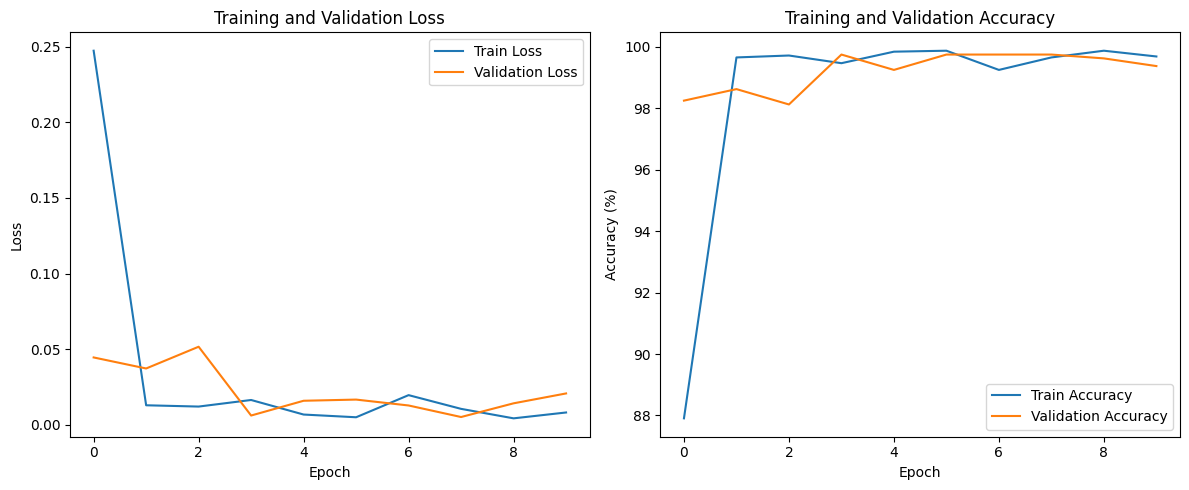

In [ ]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # Skip empty batches
        if images.size(0) == 0:
            continue
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        total_train += images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / total_train if total_train > 0 else float('inf')
    train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Skip empty batches
            if images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            total_val += images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels).sum().item()
    val_epoch_loss = val_loss / total_val if total_val > 0 else float('inf')
    val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.38%


In [ ]:
checkpoint = {
    'epoch': 10,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': val_losses[-1],
}

torch.save(checkpoint, 'convnext_checkpoint.pth')

In [4]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s 

In [2]:
# Define the ConvNeXt-based classifier
class DeepfakeClassifier(nn.Module):
    def __init__(self):
        super(DeepfakeClassifier, self).__init__()
        # Load pretrained ConvNeXt-Tiny
        self.convnext = models.convnext_tiny(weights='IMAGENET1K_V1')
        # Store the features layer for Grad-CAM
        self.features = self.convnext.features
        # Store the classifier layers
        self.avgpool = self.convnext.avgpool
        self.classifier = self.convnext.classifier

        # Modify the final classifier layer for binary classification
        num_ftrs = self.classifier[2].in_features
        self.classifier[2] = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower LR for ConvNeXt

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 151MB/s]


In [3]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

model_folder_path = '/content/drive/MyDrive/deepfake_detection/models'
checkpoint_path = os.path.join(model_folder_path, 'convnext_checkpoint.pth')

# Initialize a new model instance on the correct device
loaded_model = DeepfakeClassifier().to(device)

# Load the saved checkpoint
try:
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Error: The checkpoint file was not found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load the state dictionaries into the model
    loaded_model.load_state_dict(checkpoint['model_state_dict'])

    # Set the model to evaluation mode for inference
    loaded_model.eval()

    print(f"Model loaded successfully from {checkpoint_path}")

except FileNotFoundError as e:
    print(e)
except KeyError:
    print("Error: The checkpoint file is missing the 'model_state_dict' key. Please check if the saved checkpoint is structured correctly.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

Mounted at /content/drive
Model loaded successfully from /content/drive/MyDrive/deepfake_detection/models/convnext_checkpoint.pth


In [ ]:
# The correct way to select the last convolutional layer
# for ConvNeXt-Tiny from torchvision.
# The `features` block is composed of 4 stages (0, 1, 2, 3)
# The last layer is in the fourth stage (index 3).
target_layers = [model.convnext.features[3]]

In [5]:
import cv2
import numpy as np
from PIL import Image
import gdown
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def get_grad_cam_visualization(model, image_tensor, image_path, target_layer, category=1):
    # Create the Grad-CAM object without the 'use_cuda' argument
    # The library now handles GPU placement automatically.
    cam = GradCAM(model=model, target_layers=target_layer)

    # Use the 'category' argument to specify the class for visualization
    targets = [BinaryClassifierOutputTarget(category=category)]

    # Generate the heatmap (grayscale image)
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0]

    # Load the original image from the path
    original_image = Image.open(image_path).convert('RGB')

    # Resize the original image to the expected input size (224x224)
    original_image = original_image.resize((224, 224))

    # Convert the PIL image to a NumPy array in float32 format
    original_image = np.array(original_image, dtype=np.float32) / 255.0

    # Overlay the heatmap on the original image
    visualization = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)

    return grayscale_cam, visualization

000946.jpg already exists, skipping download


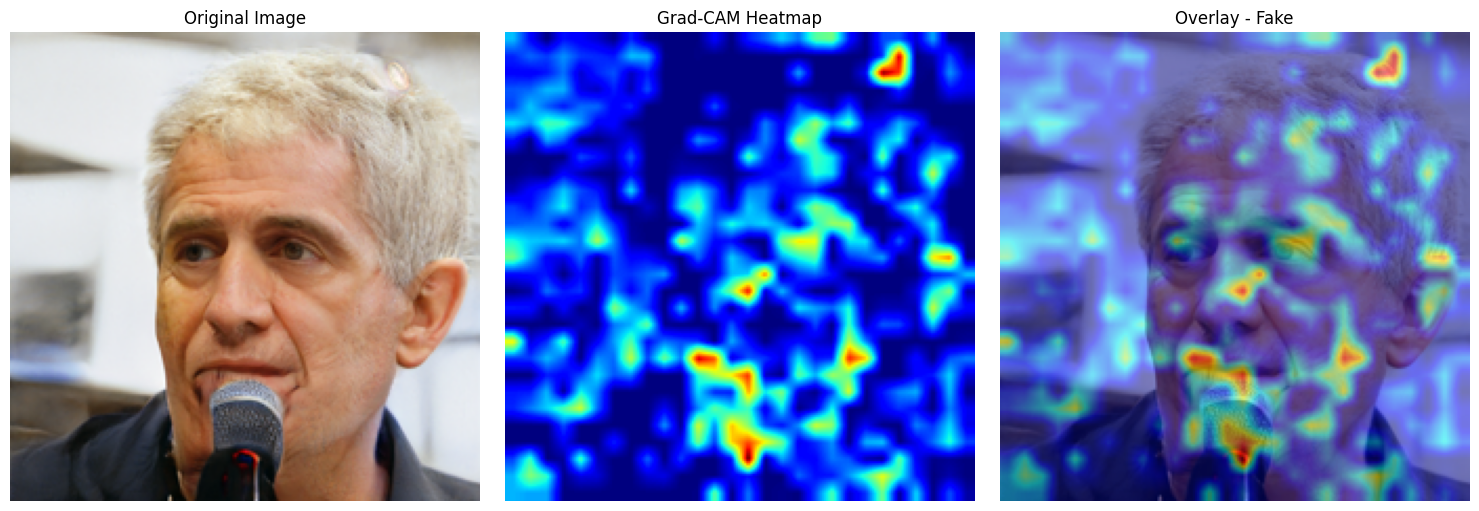

In [ ]:
model = loaded_model

image_id = "1HESPk0FBMPLDi0lheMBht6dyX6eSyx-S"
image_name = "000946.jpg"

if not os.path.exists(image_name):
    print(f"Downloading {image_name}...")
    url = f"https://drive.google.com/uc?id={image_id}"
    gdown.download(url, image_name, quiet=False)
else:
    print(f"{image_name} already exists, skipping download")

original_image = Image.open(image_name).convert('RGB')
# Resize the original image to 224x224 before passing it to the visualization function.
resized_image_for_cam = original_image.resize((224, 224))
rgb_img_float = np.float32(resized_image_for_cam) / 255
deepfake_image = rgb_img_float

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_tensor = preprocess(original_image).unsqueeze(0).to(device)
input_tensor = image_tensor.to(device)

with torch.no_grad():
  output = loaded_model(image_tensor)
  prediction = torch.sigmoid(output).item()

predicted_class = "Fake" if prediction > 0.5 else "Real"
confidence = prediction if predicted_class == "Fake" else 1 - prediction

# Generate Grad-CAM visualizations
target_category = 1 if predicted_class == "Fake" else 0

# Define the target layer for ConvNeXt-Tiny
# It's the last stage of the features block
target_layer = [model.convnext.features[3]]

# Generate and display the Grad-CAM visualization
grayscale_cam, cam_visualization = get_grad_cam_visualization(model, image_tensor, image_name, target_layer)

# Display the image using matplotlib or PIL
# Load the original image
original_image = Image.open(image_name).convert('RGB')
original_image = original_image.resize((224, 224))
original_image_np = np.array(original_image, dtype=np.float32) / 255.0

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the heatmap
axes[1].imshow(grayscale_cam, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap')
axes[1].axis('off')

# Plot the overlay
axes[2].imshow(cam_visualization)
axes[2].set_title(f"Overlay - {'Fake' if target_category == 1 else 'Real'}")
axes[2].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

000946.jpg already exists, skipping download
000022.jpg already exists, skipping download
000202.jpg already exists, skipping download
000107.jpg already exists, skipping download


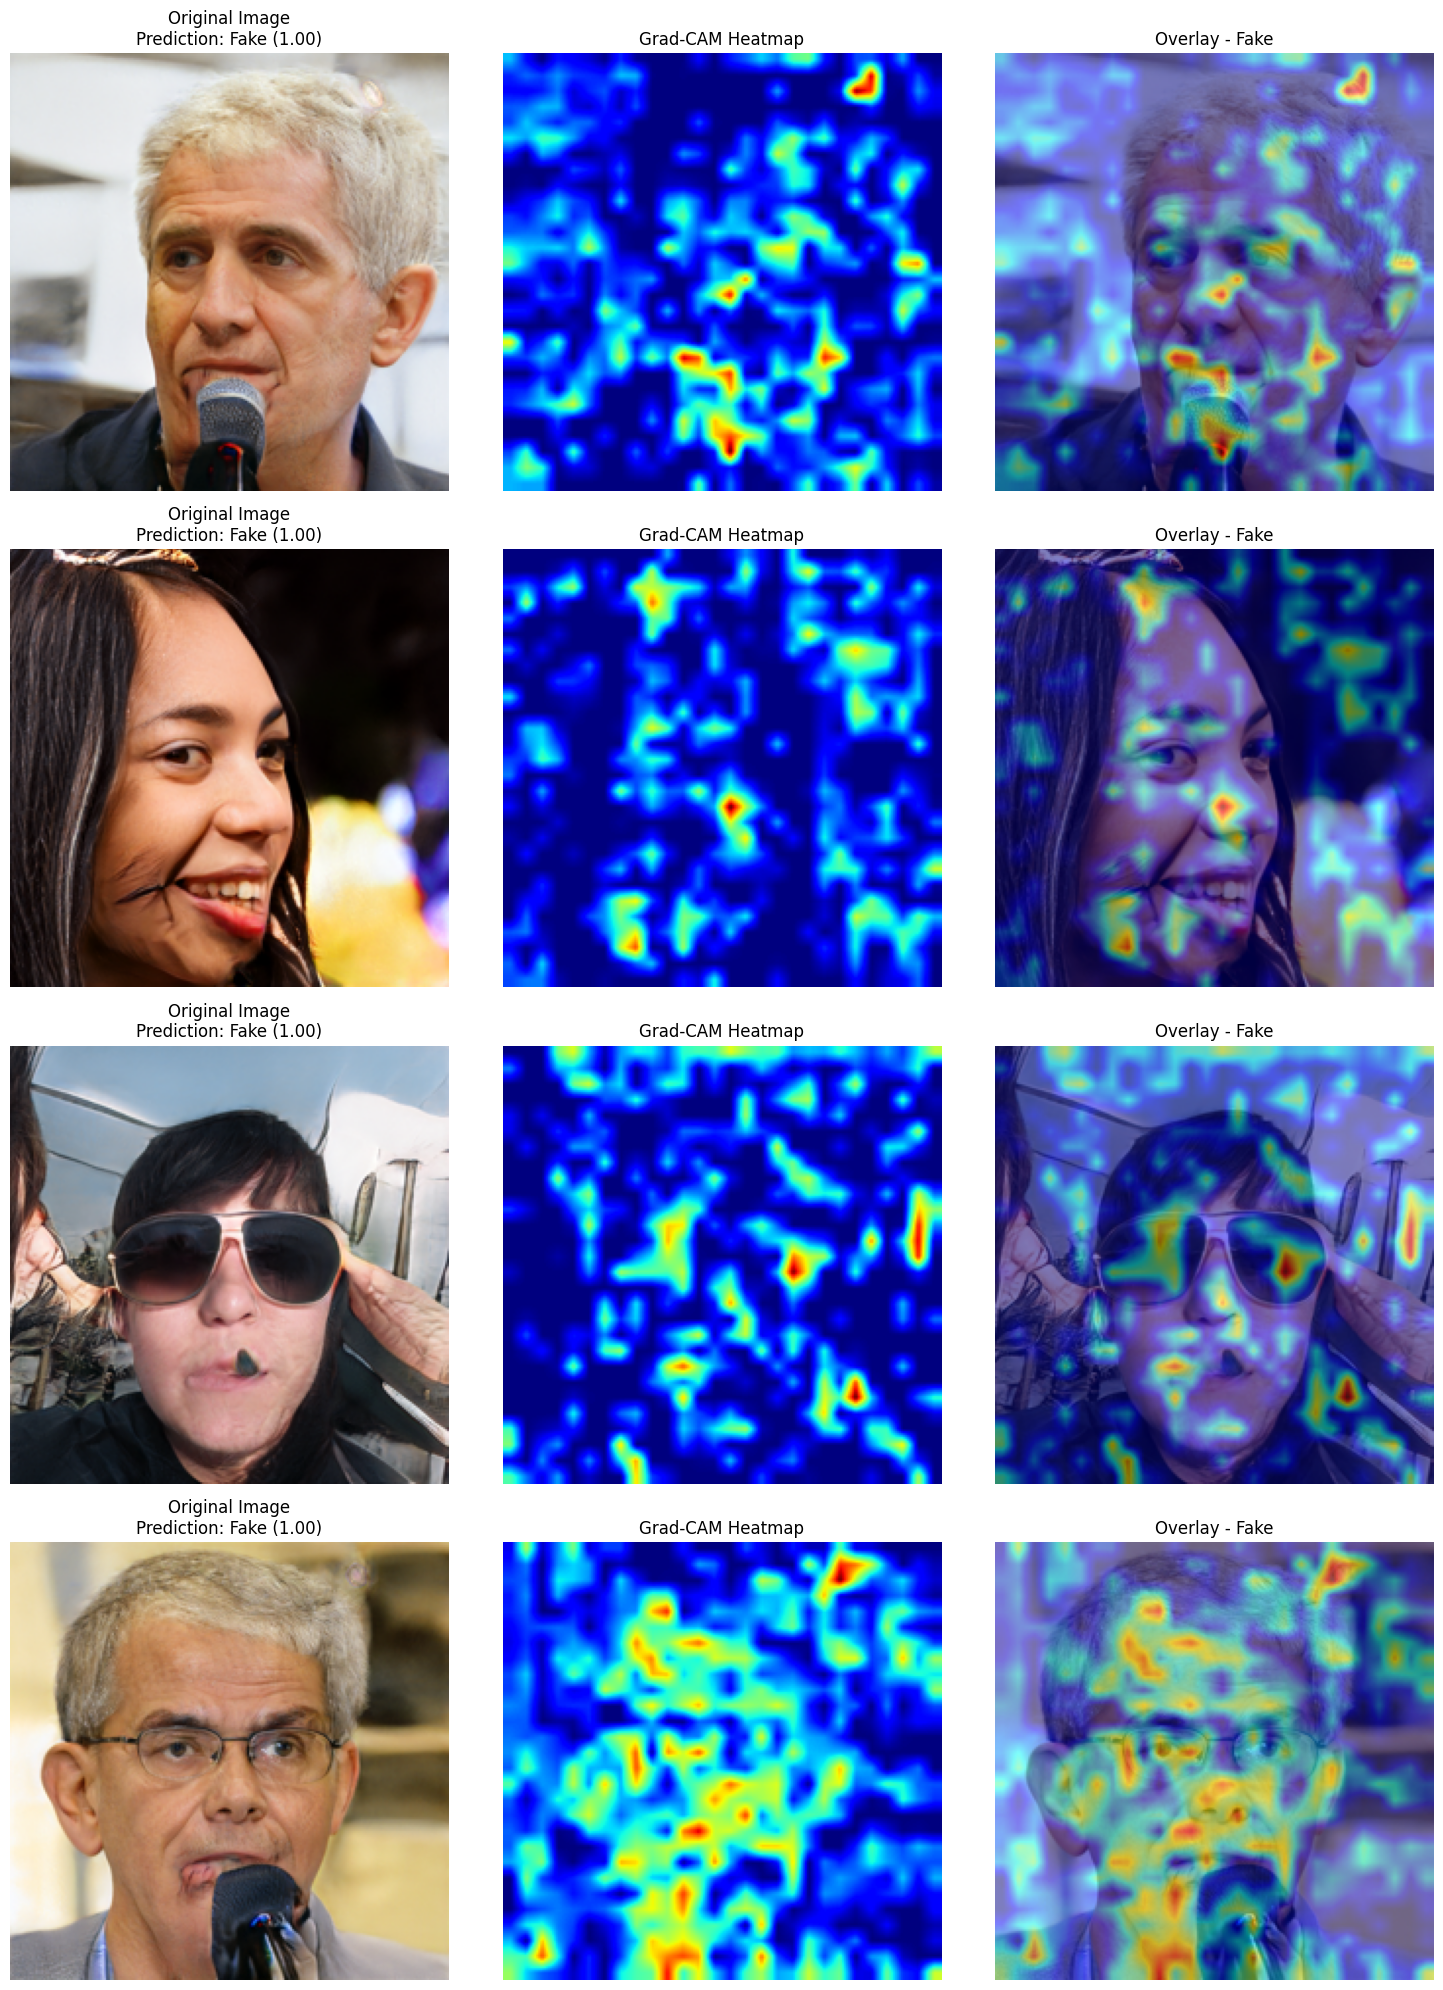

In [12]:
model = loaded_model

# List of image IDs and names
image_data = [
    {"id": "1HESPk0FBMPLDi0lheMBht6dyX6eSyx-S", "name": "000946.jpg"},
    {"id": "1o2vXPvo5rQbM1YO8VLA8E6uhsoHtkrUN", "name": "000022.jpg"},
    {"id": "1Bc8odSkvJxmA_C3hX15KS4gDnI1TfNCq", "name": "000202.jpg"},
    {"id": "1YjztpEh42U0iLNs0bU5shE-jvNIzTHke", "name": "000107.jpg"}
]

# Create a figure with 4 rows (one for each image) and 3 columns
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


for i, img_info in enumerate(image_data):
    image_id = img_info["id"]
    image_name = img_info["name"]

    # Download image if not exists
    if not os.path.exists(image_name):
        print(f"Downloading {image_name}...")
        url = f"https://drive.google.com/uc?id={image_id}"
        gdown.download(url, image_name, quiet=False)
    else:
        print(f"{image_name} already exists, skipping download")

    # Load and preprocess image
    original_image = Image.open(image_name).convert('RGB')
    resized_image = original_image.resize((224, 224))
    original_image_np = np.array(resized_image, dtype=np.float32) / 255.0

    # Prepare input tensor
    image_tensor = preprocess(original_image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.sigmoid(output).item()

    predicted_class = "Fake" if prediction > 0.5 else "Real"
    target_category = 1 if predicted_class == "Fake" else 0

    # Define the target layer for ConvNeXt-Tiny
    target_layer = [model.convnext.features[3]]

    # Generate Grad-CAM visualization
    grayscale_cam, cam_visualization = get_grad_cam_visualization(
        model, image_tensor, image_name, target_layer
    )

    # Plot the original image
    axes[i, 0].imshow(original_image_np)
    axes[i, 0].set_title(f'Original Image\nPrediction: {predicted_class} ({prediction:.2f})')
    axes[i, 0].axis('off')

    # Plot the heatmap
    axes[i, 1].imshow(grayscale_cam, cmap='jet')
    axes[i, 1].set_title('Grad-CAM Heatmap')
    axes[i, 1].axis('off')

    # Plot the overlay
    axes[i, 2].imshow(cam_visualization)
    axes[i, 2].set_title(f"Overlay - {predicted_class}")
    axes[i, 2].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully from /content/drive/MyDrive/deepfake_detection/models/convnext_checkpoint.pth
000946.jpg already exists, skipping download
Predicted class: Fake with confidence: 1.0000
Predicted category: 1
Generating CAM visualization for: GradCAM
Generating CAM visualization for: GradCAM++
Generating CAM visualization for: EigenGradCAM
Generating CAM visualization for: AblationCAM


100%|██████████| 6/6 [00:31<00:00,  5.30s/it]


Generating CAM visualization for: RandomCAM


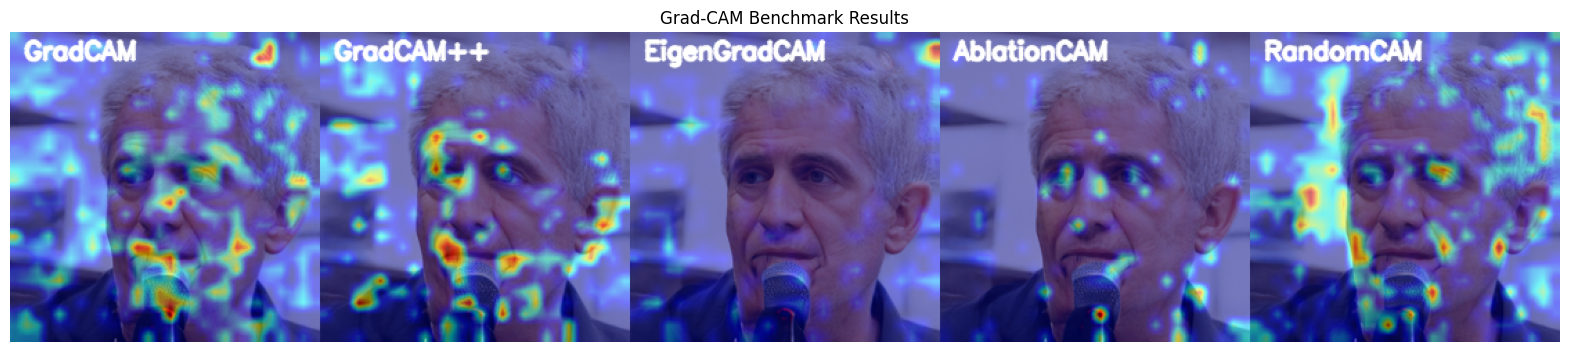

In [ ]:
import torch
import numpy as np
import cv2
import requests
from PIL import Image
import matplotlib.pyplot as plt
import gdown
import os
from torchvision import transforms
import torch.nn as nn
from torchvision import models
from google.colab import drive
from torch import optim
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

drive.mount('/content/drive')

model_folder_path = '/content/drive/MyDrive/deepfake_detection/models'
checkpoint_path = os.path.join(model_folder_path, 'convnext_checkpoint.pth')

# Initialize a new model instance on the correct device
loaded_model = DeepfakeClassifier().to(device)

# Load the saved checkpoint
try:
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Error: The checkpoint file was not found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load the state dictionaries into the model
    loaded_model.load_state_dict(checkpoint['model_state_dict'])

    # Set the model to evaluation mode for inference
    loaded_model.eval()

    print(f"Model loaded successfully from {checkpoint_path}")

except FileNotFoundError as e:
    print(e)
except KeyError:
    print("Error: The checkpoint file is missing.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

image_id = "1HESPk0FBMPLDi0lheMBht6dyX6eSyx-S"
image_name = "000946.jpg"

if not os.path.exists(image_name):
    print(f"Downloading {image_name}...")
    url = f"https://drive.google.com/uc?id={image_id}"
    gdown.download(url, image_name, quiet=False)
else:
    print(f"{image_name} already exists, skipping download")

original_image = Image.open(image_name).convert('RGB')
# Resize the original image to 224x224 before passing it to the visualization function.
resized_image_for_cam = original_image.resize((224, 224))
rgb_img_float = np.float32(resized_image_for_cam) / 255
deepfake_image = rgb_img_float

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

loaded_model.eval()
loaded_model.to(device)

image_tensor = preprocess(original_image).unsqueeze(0).to(device)
input_tensor = image_tensor.to(device)
target_layer = [model.convnext.features[3]]

def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(model, image_tensor, image_path, target_layer, category=1):
     # Define the different CAM methods to be used
    cam_methods = [
        ("GradCAM", GradCAM(model=model, target_layers=target_layer)),
        ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layer)),
        ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layer)),
        ("AblationCAM", AblationCAM(model=model, target_layers=target_layer)),
        ("RandomCAM", RandomCAM(model=model, target_layers=target_layer))
    ]

    # Use the 'category' argument to specify the class for visualization
    targets = [BinaryClassifierOutputTarget(category=category)]

    visualizations = []

    # Load and preprocess the original image once
    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((224, 224))
    original_image_np = np.array(original_image, dtype=np.float32) / 255.0

    # Loop through each CAM method and generate its visualization
    for name, cam_method in cam_methods:
        print(f"Generating CAM visualization for: {name}")

        # Generate the heatmap (grayscale image)
        grayscale_cam = cam_method(input_tensor=image_tensor, targets=targets)[0]

        # Overlay the heatmap on the original image
        visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)

        # Add a title to the visualization for clarity
        visualization = cv2.putText(
            visualization,
            name,
            (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 255, 255),
            2,
            cv2.LINE_AA
        )
        visualizations.append(visualization)

    # Stack the visualizations horizontally to create a single image
    final_visualization = np.hstack(visualizations)
    return Image.fromarray(final_visualization)

np.random.seed(42)

with torch.no_grad():
        output = loaded_model(image_tensor)
        prediction = torch.sigmoid(output).item()

predicted_class = "Fake" if prediction > 0.5 else "Real"
confidence = prediction if predicted_class == "Fake" else 1 - prediction

predicted_category = 1 if predicted_class == "Fake" else 0

# Print the predicted category to verify.
print(f"Predicted class: {predicted_class} with confidence: {confidence:.4f}")
print(f"Predicted category: {predicted_category}")

# Pass the predicted category to the benchmark function.
benchmark_visualization = benchmark(model, image_tensor, image_name, target_layer, predicted_category)

# Save the image to a file
benchmark_visualization.save('benchmark_results.png')

# Display the image using matplotlib
plt.figure(figsize=(20, 10))
plt.imshow(benchmark_visualization)
plt.axis('off')
plt.title("Grad-CAM Benchmark Results")
plt.show()

In [ ]:
# Import Gradio and other necessary libraries.
import gradio as gr
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define the target layer for ConvNeXt-Tiny
# It's the last stage of the features block
target_layer = [loaded_model.convnext.features[3]] # Use loaded_model

# The function to be used by Gradio. The input 'image' will be the file path.
def process_image(image):
    if image is None:
        return "Please upload an image.", None

    # 1. Load and preprocess the image
    original_image = Image.open(image).convert('RGB')

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image_tensor = preprocess(original_image).unsqueeze(0).to(device)

    # 2. Get model prediction and confidence
    with torch.no_grad():
        output = loaded_model(image_tensor)
        prediction = torch.sigmoid(output).item()

    predicted_class = "Fake" if prediction > 0.5 else "Real"
    confidence = prediction if predicted_class == "Fake" else 1 - prediction

    # 3. Generate Grad-CAM visualizations
    target_category = 1 if predicted_class == "Fake" else 0
    cam = GradCAM(model=loaded_model, target_layers=target_layer)
    targets = [BinaryClassifierOutputTarget(category=target_category)]

    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0]

    # Resize original image for overlay
    original_image = original_image.resize((224, 224))
    original_image_np = np.array(original_image, dtype=np.float32) / 255.0
    cam_visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)

    # 4. Create a matplotlib plot for the 3 images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(grayscale_cam, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')

    axes[2].imshow(cam_visualization)
    axes[2].set_title(f"Overlay - {predicted_class}")
    axes[2].axis('off')

    plt.tight_layout()

    # The function returns the prediction label, confidence, and the matplotlib figure.
    return {predicted_class: confidence}, fig

# Define the Gradio interface
iface = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="filepath", label="Upload an Image"),
    outputs=[
        gr.Label(label="Prediction"),
        gr.Plot(label="Grad-CAM Visualization")
    ],
    title="Deepfake Detection with Grad-CAM Visualization 🧐",
    description="Upload an image to see the model's prediction, confidence, and the areas it focuses on."
)

# Launch the app
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e86fe968681d53a21f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
